* Design a variation of a VAE that

      * takes in two inputs:

            * an MNIST image, and

            * its label (one hot encoded vector sent through an embedding layer)

* Training as you would train a VAE

* Now randomly send a MNIST image, but with a wrong label. Do this 25 times,

* And share 25 images (1 stacked image)!

### Install different required libraries

In [1]:
! pip install pytorch-lightning
!git clone https://github.com/PyTorchLightning/pytorch-lightning-bolts.git
%cd pytorch-lightning-bolts
!git checkout v0.2.5rc1
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 21.4 MB/s eta 0:00:00
Cloning into 'pytorch-lightning-bolts'...
remote: Enumerating objects: 9800, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 9800 (delta 11), reused 1 (delta 1), pack-reused 9782
Receiving objects: 100% (9800/9800), 5.09 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (7030/7030), done.
/content/pytorch-lightning-bolts
error: pathspec 'v0.2.5rc1' d

### Define VAE

In [2]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=28, num_labels=10, label_embedding_dim=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim + label_embedding_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim + label_embedding_dim, latent_dim)

        # label embedding
        self.label_embedding = nn.Embedding(num_labels, label_embedding_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch

        # label embedding
        y_embedded = self.label_embedding(y)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        x_encoded_with_labels = torch.cat([x_encoded, y_embedded], dim=1)
        mu, log_var = self.fc_mu(x_encoded_with_labels), self.fc_var(x_encoded_with_labels)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo


/content/pytorch-lightning-bolts/pl_bolts/callbacks/data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
/content/pytorch-lightning-bolts/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/content/pytorch-lightning-bolts/pl_bolts/models/self_supervised/amdim/amdim_modul

### Train VAE on CIFAR10 dataset

In [6]:
from pl_bolts.datamodules import MNISTDataModule
from torchvision.transforms import transforms
import pytorch_lightning as pl


transform = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.Grayscale(num_output_channels=3),  # convert grayscale image to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

datamodule = MNISTDataModule(data_dir='.', train_transforms=transform, test_transforms=transform)
pl.seed_everything(1234)
vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30)
trainer.fit(vae, datamodule)


INFO:lightning_lite.utilities.seed:Global seed set to 1234
<ipython-input-2-e41e98deaab3>:15: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
<ipython-input-2-e41e98deaab3>:16: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


#### Now randomly send a MNIST image, but with a wrong label. Do this 25 times,

#### And share 25 images (1 stacked image)!

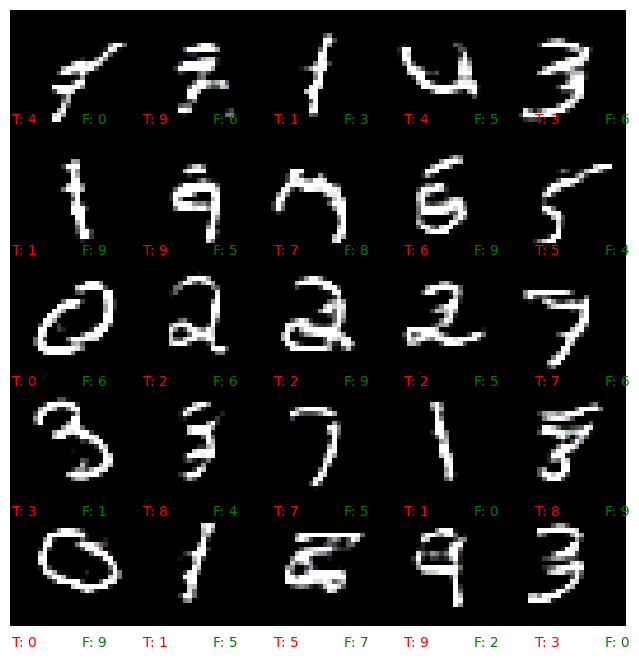

In [15]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import ImageDraw

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((24, 24)), #RuntimeError: The expanded size of the 
        #tensor (28) must match the existing size (24) at non-singleton 
        #dimension 2.  Target sizes: [3, 28, 28].  Tensor sizes: [3, 24, 24]
        transforms.Grayscale(3),  # convert 1-channel grayscale image to 3-channel grayscale
        transforms.ToTensor()
    ])
)

# Set the device to be used for tensor computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the VAE to the same device
vae.to(device)

# Set the VAE to evaluation mode
vae.eval()

# Initialize an empty tensor to store the reconstructed images and corresponding labels
#RuntimeError: The expanded size of the tensor (28) must match the existing size (24) at 
#non-singleton dimension 2.  Target sizes: [3, 28, 28].  Tensor sizes: [3, 24, 24]
reconstructed_images = torch.empty((25, 3, 24, 24))  # 3 channels instead of 1
labels = []

for i in range(25):
    # Randomly select an image and its true label from the test dataset
    index = torch.randint(len(test_dataset), size=(1,)).item()
    image, true_label = test_dataset[index]
    
    # Create a tensor with a randomly chosen incorrect label
    incorrect_label = torch.randint(low=0, high=10, size=(1,)).item()
    while incorrect_label == true_label:
        incorrect_label = torch.randint(low=0, high=10, size=(1,)).item()
    incorrect_label_tensor = torch.tensor([incorrect_label])
    
    # Move the image and label tensors to the same device as the VAE
    image = image.to(device)
    incorrect_label_tensor = incorrect_label_tensor.to(device)
    
    # Encode the image and the incorrect label into the latent space
    encoded = vae.encoder(image.unsqueeze(0))
    incorrect_label_embedding = vae.label_embedding(incorrect_label_tensor)
    encoded_with_labels = torch.cat([encoded, incorrect_label_embedding], dim=1)
    mu, log_var = vae.fc_mu(encoded_with_labels), vae.fc_var(encoded_with_labels)
    
    # Sample from the distribution
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    
    # Decode the latent vector into an image
    reconstructed_image = vae.decoder(z)
    
    # Store the reconstructed image and corresponding label in the tensors
    reconstructed_images[i] = reconstructed_image.squeeze(0)
    labels.append(f'True: {true_label}, Incorrect: {incorrect_label}')

# Concatenate the 25 reconstructed images into a single image for visualization
reconstructed_grid = torchvision.utils.make_grid(reconstructed_images, nrow=5)
reconstructed_grid = reconstructed_grid.permute(1, 2, 0).cpu().detach().numpy()

# Visualize the reconstructed image grid with labels
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(reconstructed_grid, vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

for i, label in enumerate(labels):
    row, col = i // 5, i % 5
    x = col * 28
    y = row * 28 + 24
    true_label = label.split(',')[0].split(': ')[1]
    incorrect_label = label.split(',')[1].split(': ')[1]
    ax.text(x, y, f'T: {true_label}', color='red')
    ax.text(x+15, y, f'F: {incorrect_label}', color='green')
